# **MPP2 - Handwritten Character Recognition**
- Handwritten Character Recognition (HCR) is a field of artificial intelligence focused on the development of algorithms and systems capable of recognizing and interpreting handwritten characters or symbols. This technology finds applications in various domains such as document digitization, postal services, bank check processing, and more.

# Data Collection:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- Download and unzip the dataset

In [3]:
!unzip /content/drive/MyDrive/words_image_processing_dataset_1_x4y_b5remox.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/words/h07/h07-071a/h07-071a-07-07.png  
  inflating: /content/data/__MACOSX/words/h07/h07-071a/._h07-071a-07-07.png  
  inflating: /content/data/words/h07/h07-071a/h07-071a-05-02.png  
  inflating: /content/data/__MACOSX/words/h07/h07-071a/._h07-071a-05-02.png  
  inflating: /content/data/words/h07/h07-071a/h07-071a-05-03.png  
  inflating: /content/data/__MACOSX/words/h07/h07-071a/._h07-071a-05-03.png  
  inflating: /content/data/words/h07/h07-071a/h07-071a-07-06.png  
  inflating: /content/data/__MACOSX/words/h07/h07-071a/._h07-071a-07-06.png  
  inflating: /content/data/words/h07/h07-071a/h07-071a-09-03.png  
  inflating: /content/data/__MACOSX/words/h07/h07-071a/._h07-071a-09-03.png  
  inflating: /content/data/words/h07/h07-071a/h07-071a-09-01.png  
  inflating: /content/data/__MACOSX/words/h07/h07-071a/._h07-071a-09-01.png  
  inflating: /content/data/words/h07/h07-071a/h07-071a-07-04.png  
  inflating:

In [4]:
!unzip /content/drive/MyDrive/parser_text_processing_dataset_2_fiv_9ku4h73.zip -d /content/data

Archive:  /content/drive/MyDrive/parser_text_processing_dataset_2_fiv_9ku4h73.zip
  inflating: /content/data/parser.txt  


# Import necessary libraries:

In [5]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

-  Below code reads data from a file named "parser.txt", filters out certain lines based on specific conditions, stores the remaining lines in a list, shuffles the list randomly, and returns the length of the shuffled list.

In [6]:
base_path = "data"
words_list = []

words = open(f"{base_path}/parser.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

# Data Splitting:
- We will split the dataset into three subsets with a 90:5:5 ratio (train:validation:test).

In [7]:
from sklearn.model_selection import train_test_split

# Splitting into train and test sets
train_samples, test_samples = train_test_split(words_list, test_size=0.1, random_state=42)

# Splitting test set into validation and test sets
validation_samples, test_samples = train_test_split(test_samples, test_size=0.5, random_state=42)

# Assertions to ensure correct splitting
assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")


Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


- Below code segment defines a function get_image_paths_and_labels that generates image paths and corresponding labels based on provided samples. It ensures that only valid image paths are considered, discarding those that are missing or invalid. Additionally, it uses this function to generate image paths and labels for training, validation, and testing sets.

In [8]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

- Below code segment preprocesses and analyzes the training labels to obtain key information such as the maximum label length and the character vocabulary.

In [9]:
train_labels_cleaned = [label.split(" ")[-1].strip() for label in train_labels]
characters = sorted(set(char for label in train_labels_cleaned for char in label))
max_len = max(len(label) for label in train_labels_cleaned)

print("Maximum length:", max_len)
print("Vocabulary size:", len(characters))

print("Some label samples:", train_labels_cleaned[:10])


Maximum length: 21
Vocabulary size: 78
Some label samples: ['a', 'ever', 'had', 'choice', 'main', 'sea-farers', 'a', 'animals', 'his', 'image']


In [10]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

- **Building the character vocabulary:**

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

# Create a vocabulary list
vocabulary = list(characters)

# Mapping characters to integers and vice versa.
char_to_num = StringLookup(vocabulary=vocabulary, invert=False)
num_to_char = StringLookup(vocabulary=vocabulary, invert=True)


# Resizing images without distortion

- Below code defines a function distortion_free_resize that resizes an input image to a target size while preserving its aspect ratio. The function then pads the resized image to ensure it fits exactly into the target size without distortion.
- This function ensures that the resized image fits perfectly into the target size without distortion, by applying appropriate padding and transformation operations.

In [12]:

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


- Below code segment defines functions to preprocess images and labels for a handwritten character recognition task, and prepares a TensorFlow dataset for training.

In [13]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


# Prepare tf.data.Dataset objects:

In [14]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

# Visualize a few samples
- Code segment provides a visual representation of a batch of images and their associated labels, allowing for a quick inspection of the data and model predictions during the training process.

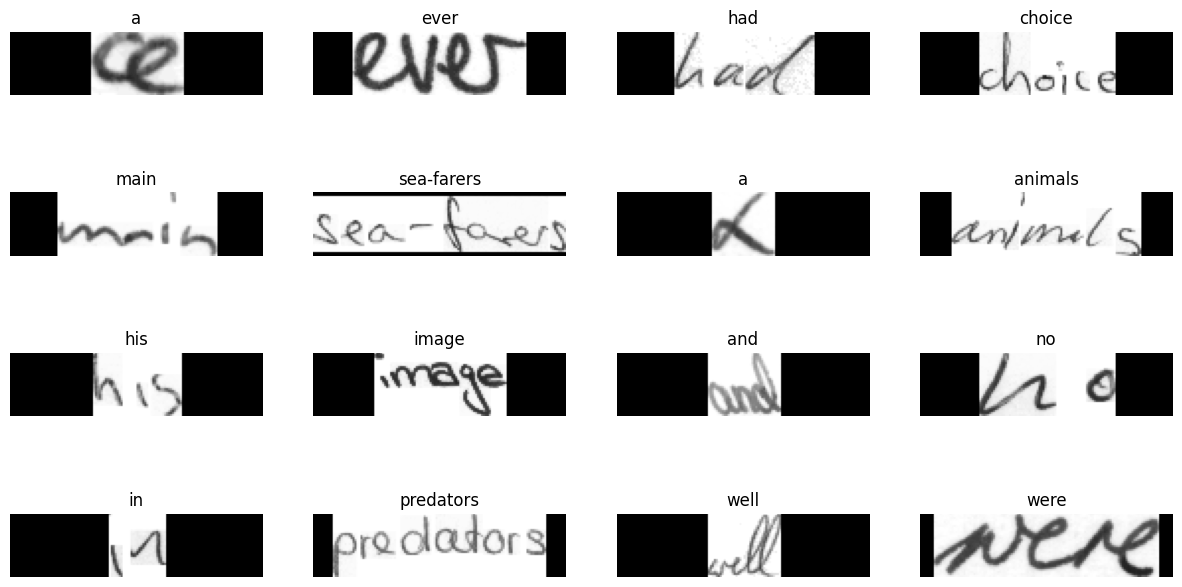

In [15]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

# Model building:
- Our model will use the CTC loss as an endpoint layer.

In [16]:

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                             

# Evaluation metric
Edit Distance is the most widely used metric for evaluating OCR models.

In [17]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [18]:

def calculate_edit_distance(labels, predictions):
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


# Training
Now we are ready to kick off model training.

In [22]:
epochs = 50  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs
)


Epoch 1/50
1357/1357 [==============================] - 89s 60ms/step - loss: 13.4123 - val_loss: 11.7801
Epoch 2/50
1357/1357 [==============================] - 79s 58ms/step - loss: 10.5876 - val_loss: 9.5448
Epoch 3/50
1357/1357 [==============================] - 84s 62ms/step - loss: 8.8520 - val_loss: 7.6755
Epoch 4/50
1357/1357 [==============================] - 73s 53ms/step - loss: 7.1737 - val_loss: 5.9680
Epoch 5/50
1357/1357 [==============================] - 74s 54ms/step - loss: 5.9013 - val_loss: 4.8666
Epoch 6/50
1357/1357 [==============================] - 85s 63ms/step - loss: 5.0342 - val_loss: 4.1105
Epoch 7/50
1357/1357 [==============================] - 83s 61ms/step - loss: 4.4102 - val_loss: 3.6277
Epoch 8/50
1357/1357 [==============================] - 84s 62ms/step - loss: 3.9850 - val_loss: 3.2681
Epoch 9/50
1357/1357 [==============================] - 91s 67ms/step - loss: 3.6559 - val_loss: 3.2677
Epoch 10/50
1357/1357 [==============================] - 81s 

-  Below code segment defines a function decode_batch_predictions which decodes the predictions made by a neural network model for a batch of input images. It uses Connectionist Temporal Classification (CTC) decoding to convert the model's output into text predictions. Additionally, the code iterates over a batch of test samples, makes predictions using a pre-trained model, decodes these predictions, and visualizes the input images alongside the corresponding predicted text. Finally, it displays a grid of images with their predicted texts for visual inspection. This process allows for evaluating the performance of the handwritten character recognition model on real test data.

2/2 [==============================] - 1s 10ms/step


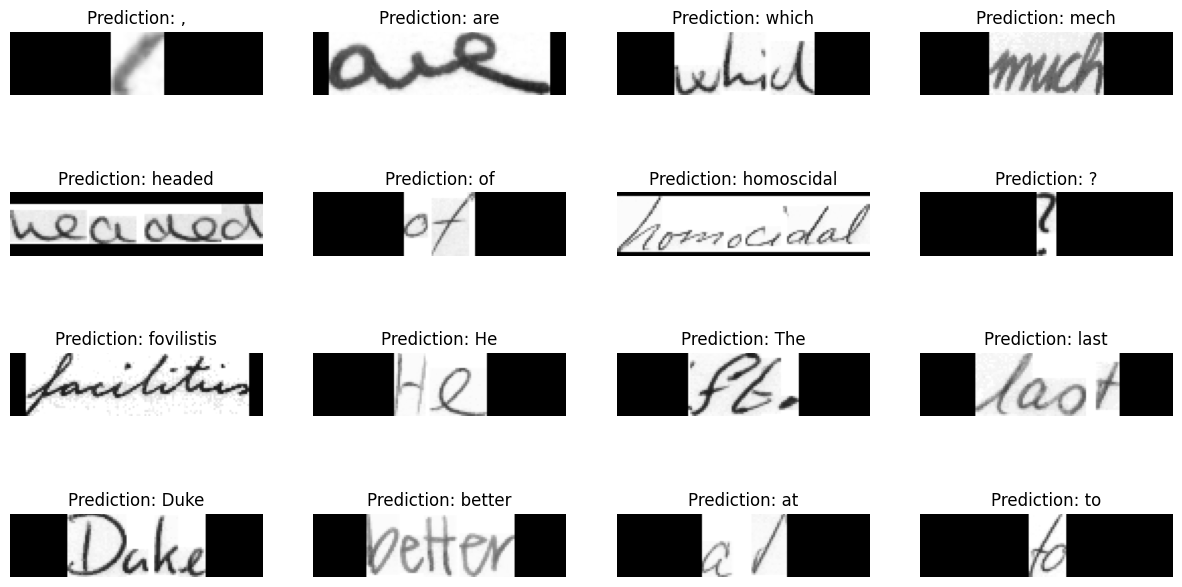

In [23]:

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]

    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()